In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
import plotly.express as px
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph

from utils import load_model, build_vocab
%load_ext autoreload
%autoreload 2

In [4]:
SEED = 42

In [6]:
emb_vectors, model = load_model("data/word2vec/word2vec.model")
X = np.array([list(v) for k, v in emb_vectors.items()])

## Getting song information

In [6]:
song_ids = np.array([k for k, v in emb_vectors.items()])

In [7]:
sample = pd.read_pickle('data/pickle/sample')

In [9]:
sample.shape

(19098850, 7)

In [20]:
sample2 = sample.drop(columns=['user_id', 'timestamp', 'artist_id','track_id'])

In [25]:
count = sample2.value_counts(['artist_name', 'track_name'])

In [37]:
song_counts = pd.DataFrame(count)

In [34]:
sample_songs = sample.drop(columns=['user_id', 'timestamp', 'artist_id','track_id'])
sample_songs = sample_songs.drop_duplicates(subset=['song_id'])
sample_songs = sample_songs[sample_songs['song_id'].isin(song_ids)]

In [39]:
sample_songs = pd.merge(sample_songs, song_counts, how='left', on=['artist_name','track_name'])

In [62]:
sample_songs = sample_songs.rename(columns={0: "occur"})

In [41]:
song_id_dict = {}
for i in range(len(song_ids)):
    song_id_dict[song_ids[i]] = i 

In [42]:
sample_songs['X_index'] = sample_songs['song_id'].map(song_id_dict)

In [43]:
sample_songs = sample_songs.set_index('X_index')

In [44]:
sample_songs = sample_songs.sort_index()
sample_songs

,artist_name,track_name,song_id,0
X_index,,,,
0,The Postal Service,Such Great Heights,4616724870,3991
1,Boy Division,Love Will Tear Us Apart,670684783,3651
2,Radiohead,Karma Police,3583077772,3533
3,Death Cab For Cutie,Soul Meets Body,1166923991,3479
4,Muse,Supermassive Black Hole,3090101702,3463
...,...,...,...,...
527547,Dylan Vs Korn,Falling Away (Dylan Remix),132745488902,5
527548,Dream Theater,Disposable Heroes,1386951220,5
527549,Britney Spears,Body And Soul,703180912,5


In [45]:
song_tags = pd.read_pickle('data/pickle/song_tags_top1')

In [46]:
song_tags.head()

,user_id,timestamp,artist_id,artist_name,track_id,track_name,top_tag
0,user_000001,2009-05-04 23:08:57+00:00,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007,dance
1,user_000001,2009-05-04 13:54:10+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15),
2,user_000001,2009-04-25 14:09:18+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15),
3,user_000001,2009-04-21 18:23:34+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15),
4,user_000001,2009-04-20 13:27:17+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15),


In [47]:
song_tags = song_tags.drop_duplicates(subset=['track_name'])

In [48]:
song_tags = song_tags.drop(columns=['user_id', 'timestamp', 'artist_id','track_id'])

In [49]:
sample_songs = pd.merge(sample_songs, song_tags, how='left', on=['artist_name','track_name'])

In [63]:
sample_songs.head()

,artist_name,track_name,song_id,occur,top_tag
0,The Postal Service,Such Great Heights,4616724870,3991,NaN
1,Boy Division,Love Will Tear Us Apart,670684783,3651,rock
2,Radiohead,Karma Police,3583077772,3533,alternative
3,Death Cab For Cutie,Soul Meets Body,1166923991,3479,indie
4,Muse,Supermassive Black Hole,3090101702,3463,alternative rock


In [144]:
usr_counts = sample[['user_id', 'song_id']]
usr_counts = usr_counts.drop_duplicates()
usr_counts = usr_counts.value_counts('song_id')
usr_counts_df = pd.DataFrame(usr_counts, columns=['usr_count'])

In [145]:
sample_songs = pd.merge(sample_songs, usr_counts_df, how='left', on=['song_id'])

In [163]:
sample_songs.head()

,artist_name,track_name,song_id,occur,top_tag,usr_count,usr_spread,avg_listens
0,The Postal Service,Such Great Heights,4616724870,3991,NaN,321,0.324,12.4
1,Boy Division,Love Will Tear Us Apart,670684783,3651,rock,318,0.321,11.5
2,Radiohead,Karma Police,3583077772,3533,alternative,346,0.349,10.2
3,Death Cab For Cutie,Soul Meets Body,1166923991,3479,indie,233,0.235,14.9
4,Muse,Supermassive Black Hole,3090101702,3463,alternative rock,263,0.265,13.2


In [162]:
sample_songs['usr_spread'] = np.round(sample_songs['usr_count'] / sample['user_id'].nunique(), 3)

In [160]:
sample_songs['avg_listens'] = np.round(sample_songs['occur'] / sample_songs['usr_count'], 1)

## Clustering

In [7]:
def compute_bic(kmeans, X):
    """
    Computes the BIC metric

    :param kmeans: clustering object from scikit learn
    :param X: np array of data points
    :return: BIC
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels = kmeans.labels_
    # number of clusters
    k = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    # size of data set
    N, D = X.shape
    # compute variance for all clusters beforehand
    cl_var = (1.0 / (N - k) / D) * sum([sum(distance.cdist(X[np.where(labels == i)], \
                                    [centers[0][i]],'euclidean') ** 2) for i in range(k)])
    LL = np.sum([n[i] * np.log(n[i]) -
                  n[i] * np.log(N) -
                  ((n[i] * D) / 2) * np.log(2 * np.pi * cl_var) -
                  ((D / 2)*(n[i] - 1))  for i in range(k)])
    
    d = (k - 1) + 1 + k * D
    const_term = (d / 2) * np.log(N)
    BIC = LL - const_term
    return BIC
    
def plot_metrics(n_clusters_list, metric_dictionary):
    """
    Plots metric dictionary (auxilary function)
    [Optional]
    :param n_clusters_list: List of number of clusters to explore
    :param metric_dictionary: 
    :return: 
    """
    fig = plt.figure(figsize=(12, 10), dpi=80)
    i = 1

    for metric in metric_dictionary.keys():
        plt.subplot(2, 2, i)
        plt.plot(n_clusters_list, metric_dictionary[metric], '-o')
        plt.xlabel('Number of clusters')
        plt.ylabel(metric)
        plt.xticks(n_clusters_list)
        i += 1

    
def get_heuristics_kmeans(X, n_clusters_list = range(2,10)):
    """
    Calculates heuristics for optimal number of clusters with K-Means 
    
    :param n_clusters_list: List of number of clusters to explore
    :param X: np array of data points 
    """
    silhouette_list = []
    distortion_list = []
    bic_list = []
   
    for n in tqdm(n_clusters_list):
        kmeans = KMeans(n_clusters=n, random_state=SEED)
        y_pred = kmeans.fit_predict(X)

#         silhouette = silhouette_score(X, y_pred) #Commented out because too long to compute
#         silhouette_list.append(silhouette)
        distortion = kmeans.inertia_
        distortion_list.append(distortion)
        bic = compute_bic(kmeans, X)
        bic_list.append(bic)
        
    metric_dictionary = {'BIC': bic_list,
                         'Distortion': distortion_list,
#                          'Silhouette': silhouette_list
                        }
    
    plot_metrics(n_clusters_list, metric_dictionary)

100%|██████████| 8/8 [04:06<00:00, 30.81s/it]


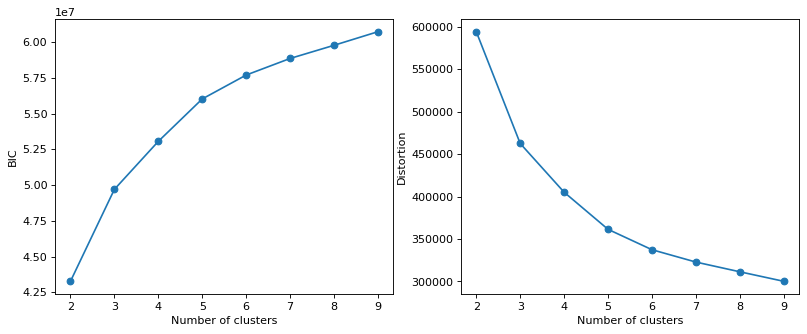

In [8]:
get_heuristics_kmeans(X)

In [13]:
def plot_clusters_2D(X, clusters):
    # apply PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(X).T
    x, y = components[0], components[1]
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.scatter(x=x, y=y, c=clusters)
    plt.xlabel('PCA first dimension')
    plt.ylabel('PCA second dimension')
    plt.title(f"Clusters on 2 dimensions of the song embeddings")

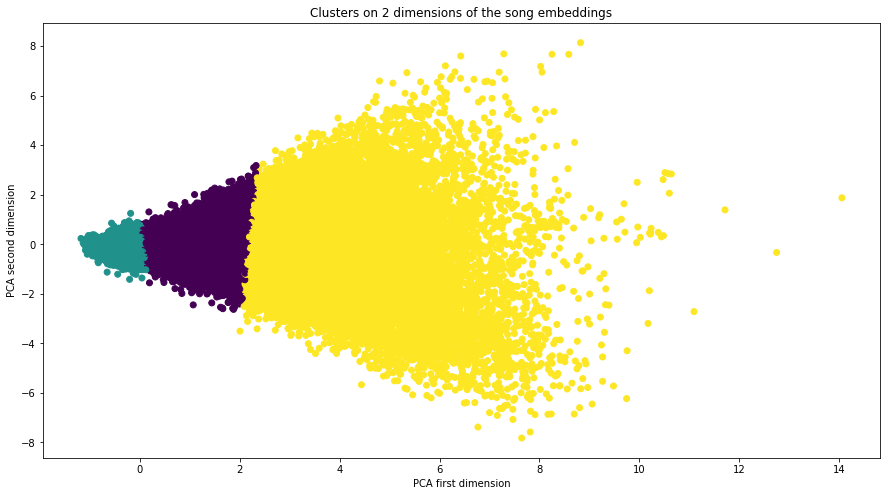

In [14]:
#The cluster assignments for each embedding
clusters = KMeans(n_clusters=3, random_state=SEED).fit_predict(X)
plot_clusters_2D(X, clusters)

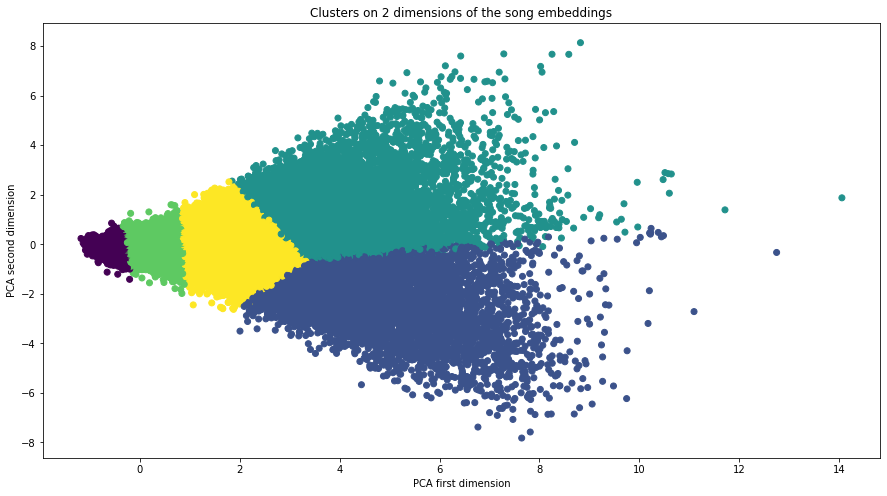

In [15]:
clusters = KMeans(n_clusters=5, random_state=SEED).fit_predict(X)
plot_clusters_2D(X, clusters)

In [189]:
def plotly_clusters_2D(X, clusters, k):
    title = str(k) + "-Means Clustering on 2D PCA of the song embeddings"
    
    # apply PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(X).T
    
    x, y = components[0], components[1]
    
    data = {'PC1' : x, 'PC2' : y, 'artist_name' : list(sample_songs['artist_name']), 'track_name' : list(sample_songs['track_name']), 'top_tag' : list(sample_songs['top_tag']), 'occur' : list(sample_songs['occur']), 'usr_count' : list(sample_songs['usr_count']), 'usr_spread' : list(sample_songs['usr_spread']),  'avg_listens' : list(sample_songs['avg_listens'])}
    df = pd.DataFrame(data, columns = ['PC1', 'PC2', 'artist_name', 'track_name', 'top_tag', 'occur', 'usr_count', 'usr_spread', 'avg_listens'])
    
    fig = px.scatter(df, x='PC1', y='PC2', color=clusters, hover_data=['artist_name', 'track_name', 'top_tag', 'occur', 'usr_count', 'usr_spread', 'avg_listens'], title=title)
    fig.show()

In [ ]:
def plotly_column_2D(X, column, plottitle):
    title = plottitle + " on 2 dimensions of the song embeddings"
    
    # apply PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(X).T
    
    x, y = components[0], components[1]
    
    data = {'PC1' : x, 'PC2' : y, 'artist_name' : list(sample_songs['artist_name']), 'track_name' : list(sample_songs['track_name']), 'top_tag' : list(sample_songs['top_tag']), 'occur' : list(sample_songs['occur']), 'usr_count' : list(sample_songs['usr_count']), 'usr_spread' : list(sample_songs['usr_spread']),  'avg_listens' : list(sample_songs['avg_listens'])}
    df = pd.DataFrame(data, columns = ['PC1', 'PC2', 'artist_name', 'track_name', 'top_tag', 'occur', 'usr_count', 'usr_spread', 'avg_listens'])
    
    fig, ax = plt.subplots(figsize=(15, 8))
    fig = px.scatter(df, x='PC1', y='PC2', color=column, hover_data=['artist_name', 'track_name', 'top_tag', 'occur', 'usr_count', 'usr_spread', 'avg_listens'], title=title)
    fig.show()

In [ ]:
plotly_clusters_2D(X, clusters, 3)

In [ ]:
plotly_column_2D(X, 'occur', "Song Occurence")

In [ ]:
plotly_column_2D(X, 'usr_count', "Song User Popularity")